# Deep Learning
## Summative assessment
### Coursework 1

#### Instructions

This coursework is released on **Tuesday 18th February 9.00** and is due by **Tuesday 11th March 9.00**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 50 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks shown per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for face verification. This is the problem of determining whether or not two images are of the same person.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

The data required for this assessment can also be downloaded from [this link](https://drive.google.com/file/d/1guvJwIdHKi4-AFRPs0v-6kfHZhEuo8x8/view?usp=sharing) in case you would prefer to work locally.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and PDF report.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF/HTML file(s) by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [ ]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import keras as keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# My imports and setup
import tensorflow as tf 
import time
import random
from keras import layers, models, optimizers
from sklearn.metrics import roc_auc_score, average_precision_score
AUTOTUNE = tf.data.AUTOTUNE

#### CASIA-Webface Dataset

This assessment makes use of the CASIA-Webface dataset, which is used for face verification and face identification tasks. The complete dataset consists of 494,414 face images of 10,575 real identities collected from the web. In this assessment, a smaller subset of the dataset has been prepared for you.

The dataset was first introduced in the following paper:

*  Yi, D., Lei, Z., Liao, S. and Li, S.Z. (2014), "Learning Face Representation from Scratch", arXiv preprint, abs/1411.7923.

The data subset is available for you in the folder `./data/casia-webface`.

#### Contrastive learning

Your task in this assessment is to develop a deep learning model that can be used to verify if two images belong to the same person or not. The model will take an image as input, and output a fixed size embedding. The model will be trained such that different images belonging to the same identity should have embeddings that are close to each other (in some sense), and images belonging to different identities should have embeddings that are far apart.

The training algorithm you will use for this will be a form of contrastive learning. This is a learning paradigm where the objective function compares different examples in the dataset.

In particular, to train your model you will use a loss function that takes three examples: an anchor input $\mathbf{x}$, a positive example $\mathbf{x}^+$ that is similar to the anchor (the same identity), and a negative example $\mathbf{x}^-$ that is different to the anchor. The objective for the network is to embed the images such that the similarity between the anchor and positive example is maximised (or distance is minimised), and the similarity between the anchor and negative example is minimised (distance is maximised).

<center><img src="figures/contrastive-learning.png" alt="Similarity of representations" style="width: 450px;"/></center>
<center>The model's objective is to minimize the distance (in embedding space) between an anchor and a positive example, both of which have the same identity, and maximize the distance between the anchor and a negative example of a different identity</center>
<br>

The loss function you will use is the circle loss, given by:

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$
where $s_p$ (resp. $s_n$) is the positive (resp. negative) similarity score computed between the anchor and positive (resp. anchor and negative) examples, according to some choice of similarity measure in the embedding space. The hyperparameters $\alpha_p>0$ and $\alpha_n>0$ are example-specific weightings to emphasise either the positive or negative similarity scores in the gradient updates, and $\Delta_p>0$ and $\Delta_n>0$ are the positive and negative margins. 

The circle loss was introduced in the following paper:

* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

You will need to implement a custom data loading pipeline and custom training loop, as well as designing a dedicated model architecture that produces an embedding for a given input image. Details of the data loading and training procedures will be up to you to decide. You will process the data, train and evaluate the specified model, and then write a report to summarise the experiments and results.

The data processing, model design, training algorithm and evaluation will potentially require several hyperparameter choices, and you should experiment with different choices during the development of your model. In question 4 you will write a report detailing the experiments carried out. It is up to you which experiments you will run. It is not necessary to include all experiments carried out in code in this notebook - you only need to include the code for the final choice of hyperparameters (in order to avoid overly long notebook submissions).

### Question 1 (Total 8 marks)

a) In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. For example, it will be helpful to compute the number of distinct identities in the dataset, and visualise some of the images. You can also use comments and/or markdown as appropriate.

**(3 marks)**

Count of distinct identities: 8000
Total number of .jpeg images: 211958
Min images per identity: 10
Max images per identity: 50
Mean images per identity: 26.49475
Median images per identity: 23.0


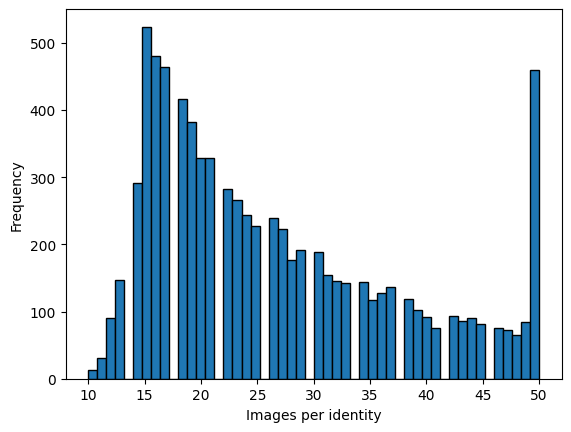

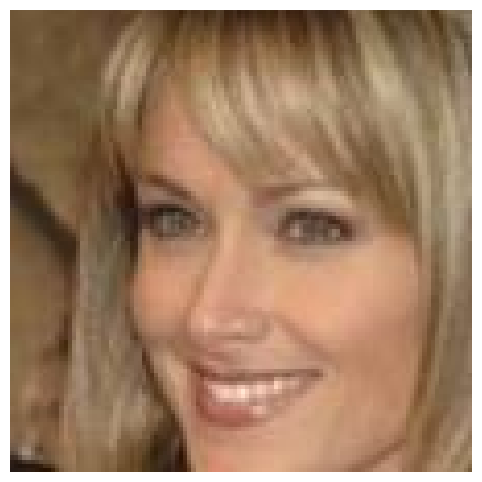

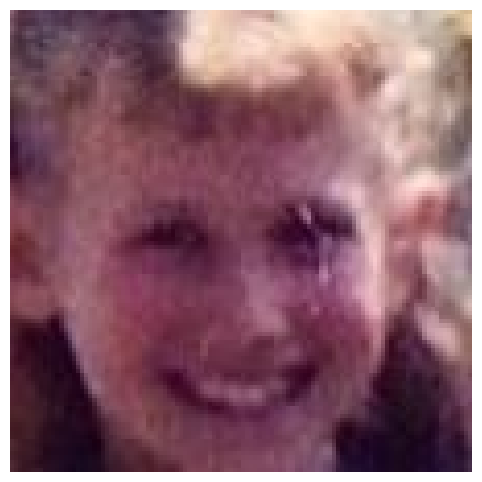

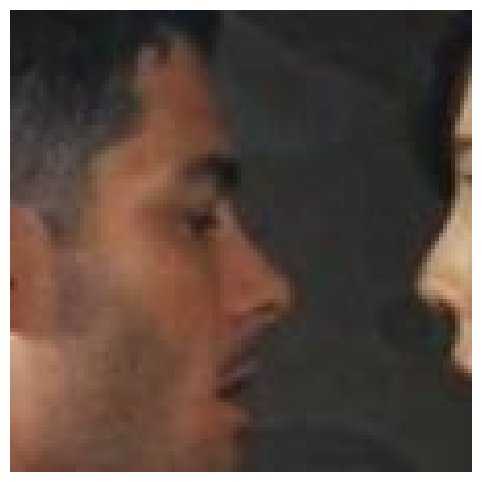

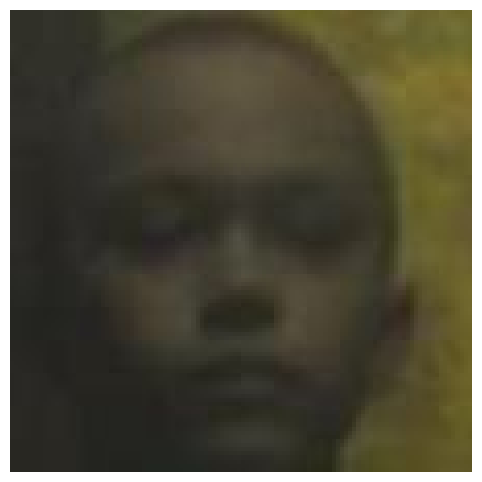

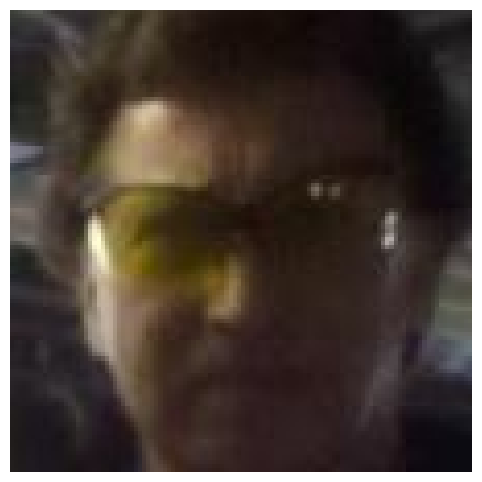

In [9]:

PATH = "./data/casia-webface"

def get_image_filepaths(data_directory=PATH):
    image_filepaths = []
    for identity_dir in os.listdir(data_directory):
        identity_path = os.path.join(data_directory, identity_dir)
        
        if os.path.isdir(identity_path):  
            for file_name in os.listdir(identity_path):
                file_path = os.path.join(identity_path, file_name)
                if os.path.isfile(file_path):
                    image_filepaths.append(file_path)

    return image_filepaths
                
def sample_random_images(number_of_images, image_filepaths):
    for _ in range(number_of_images):
        i = np.random.choice(len(image_filepaths))
        img_filepath = image_filepaths[i]
        raw_img = keras.utils.load_img(img_filepath, color_mode="rgb")
        img_array = keras.utils.img_to_array(raw_img, dtype='int32')

        plt.figure(figsize=(8, 6))
        plt.imshow(img_array)
        plt.axis('off')
        plt.show()

def eda(data_directory=PATH,number_of_images_to_show=5):

    count = len([dirname for dirname in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dirname))])
    print(f"Count of distinct identities: {count}")

    image_count = sum(
        len([file for file in files if file.endswith(".jpeg")]) 
        for _, _, files in os.walk(data_directory)
    )
    print(f"Total number of .jpeg images: {image_count}")

    file_counts = []
    for dirname in os.listdir(data_directory):
        dir_path = os.path.join(data_directory, dirname)
        if os.path.isdir(dir_path): 
            num_images = len([file for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))])
            file_counts.append(num_images)

    print(f"Min images per identity: {min(file_counts)}")
    print(f"Max images per identity: {max(file_counts)}")
    print(f"Mean images per identity: {np.mean(file_counts)}")
    print(f"Median images per identity: {np.median(file_counts)}")

    plt.hist(x=file_counts,bins=50,edgecolor='black')
    plt.xlabel('Images per identity')
    plt.ylabel('Frequency')
    plt.show()

    image_filepaths = get_image_filepaths(data_directory)
    sample_random_images(number_of_images_to_show,image_filepaths)

eda()

From the above EDA we observe that there are 8000 distinct classes (individuals) in the dataset, each with a variable number of associated images. The total number of images in the dataset is 211958. 

A histogram of class sizes has been plotted, indicating that the number of images per person is quite variable. This should be bore in mind during design and training in case it is relevant to creating a successful model.

Five random images have been sampled to illlustrate the data being worked with. The samples (along with extensive extra manual inspection) reveal several general qualities of the images: 
- The images are generally centred on the subject's face, but this is typically not precise 
- Whilst the images are all of faces, they are still varied e.g., not all images taken "front-on", different facial expressions, hairstyles, clothing, background...
- The dataset contains a mixture of black & white and colour photos
- The images are of size 112x112

b) Create the dataset object(s) that you will use to train and evaluate your model. The only requirements for your datasets are as follows:

* You should use either TensorFlow Datasets or PyTorch Datasets/DataLoaders. 
* A number of identities should be selected, and for each identity a maximum number of images should be selected.
* The dataset should return an aligned pair of Tensors `(identities, images)` with shapes `(N,)` and `(N, height, width, channels)`, where `N` is the total number of images selected across all selected identities.

You can use any tools from Keras, TensorFlow or PyTorch that might be useful for this task.

Demonstrate that your dataset creation and processing is working as intended.

**(5 marks)**

In [10]:
def build_label_to_filepaths(data_dir="./data/casia-webface"):
    label_to_filepaths = {}
    all_directories = sorted([
        d for d in os.listdir(data_dir) 
        if os.path.isdir(os.path.join(data_dir, d))
    ])

    for directory in all_directories:
        label_int = int(directory)
        subdir = os.path.join(data_dir, directory)
        filepaths = []
        for fname in os.listdir(subdir):
            fpath = os.path.join(subdir, fname)
            if  fname.lower().endswith(".jpeg") and os.path.isfile(fpath):
                filepaths.append(fpath)
        if filepaths:
            label_to_filepaths[label_int] = filepaths

    return label_to_filepaths

def decode_and_resize(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [112, 112])
    img = img/255
    return img

def load_decode_batch(filepath_batch, label_batch):
        images = tf.map_fn(
            decode_and_resize, 
            filepath_batch, 
            fn_output_signature=tf.float32
        )
        return images, label_batch

def build_triplet_compatible_dataset(label_to_filepaths,
                                    num_identities_per_batch=80,
                                    images_per_identity=10,
                                    max_batches=200,
                                    shuffle=True):
    valid_labels = []
    for label, paths in label_to_filepaths.items():
        if len(paths) >= images_per_identity:
            valid_labels.append(label)
    if not valid_labels:
        raise ValueError("No identity has enough images to sample from. Cjeck the dataset and requested number of images per identity.")

    batch_filepaths_list = []
    batch_labels_list = []
    batch_size = num_identities_per_batch * images_per_identity

    for _ in range(max_batches):
        chosen_labels = random.sample(valid_labels, k=num_identities_per_batch)
        these_filepaths = []
        these_labels = []
        for label in chosen_labels:
            paths_for_label = label_to_filepaths[label]
            chosen_image_paths = random.sample(paths_for_label, k=images_per_identity)
            these_filepaths.extend(chosen_image_paths)
            these_labels.extend([label] * images_per_identity)
        
        if len(these_filepaths) == batch_size:
            batch_filepaths_list.append(these_filepaths)
            batch_labels_list.append(these_labels)

    filepaths_dataset = tf.data.Dataset.from_tensor_slices(batch_filepaths_list)
    labels_dataset    = tf.data.Dataset.from_tensor_slices(batch_labels_list)
    ds = tf.data.Dataset.zip((filepaths_dataset, labels_dataset))

    if shuffle:
        ds = ds.shuffle(len(batch_filepaths_list))

    ds = ds.map(load_decode_batch, num_parallel_calls=AUTOTUNE) # autotune for memory management 
    ds = ds.prefetch(AUTOTUNE) # autotune for memory management 
    return ds

label_to_filepaths = build_label_to_filepaths("./data/casia-webface")
example_dataset = build_triplet_compatible_dataset(label_to_filepaths,5,5,10,True)
print(example_dataset) # Correct shape can be seen in this printout

<_PrefetchDataset element_spec=(TensorSpec(shape=(25, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(25,), dtype=tf.int32, name=None))>


### Question 2 (Total 20 marks)

a) Recall the circle loss is given by
~
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],\tag{1}
$$

where $\alpha_p>0$, $\alpha_n>0$, $\Delta_p>0$ and $\Delta_n>0$ are hyperparameters, and $s_p$ and $s_n$ are the similarity scores between anchor-positive and anchor-negative pairs according to some similarity measure.

The [triplet loss](https://en.wikipedia.org/wiki/Triplet_loss) is a similar loss function for contrastive learning that was developed a few years earlier. It is given by:

$$
\mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)\tag{2}
$$

where $f_\theta$ is a network that maps images to a fixed-size embedding, $\mathbf{x}$ is an anchor example, $\mathbf{x}^+$ is a corresponding positive example, and $\mathbf{x}^-$ is a negative example, and $m>0$ is a hyperparameter that sets the minimum offset between distances of similar vs dissimilar pairs. 

Show that the triplet loss can be derived from the circle loss as a certain limit, with a certain choice of hyperparameters $\alpha_p$, $\alpha_n$, $\Delta_p$ and $\Delta_n$ and similarity measure.

**(2 marks)**

Let $\alpha_p=1, \alpha_n=1, \Delta_pm=m$ and $\Delta_n=0$, 

Then 

$$\mathcal{L}_{\textrm{circle}^*}(s_p, s_n)=\frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (s_n  - s_p + m))\right]$$ 

Taking the limit of this as $\gamma \rightarrow \infty$, if $s_n - s_p + m \le 0$:

$$\mathcal{L}_{\textrm{circle}^*}(s_p, s_n)\rightarrow 0 $$
as
$\frac{1}{\gamma}$ and $\log\left[ 1 + \exp(\gamma (s_n  - s_p + m))\right]$ both $ \rightarrow 0$

The postive case, taking the limit of this as $\gamma \rightarrow \infty$, if $s_n - s_p + m > 0$:

$$\mathcal{L}_{\textrm{circle}^*}(s_p, s_n)\rightarrow s_n  - s_p + m$$

as $1 + \exp(\gamma (s_n  - s_p + m)) \approx \exp(\gamma (s_n  - s_p + m))$ as $\gamma$ grows, giving $\mathcal{L}_{\textrm{circle}^*}(s_p, s_n)=\frac{1}{\gamma}\log\left[\exp(\gamma (s_n  - s_p + m))\right] = s_n  - s_p + m$ when $\gamma$ is large.

Putting these together gives: 

$$\lim_{\gamma \rightarrow \infty}\mathcal{L}_{\textrm{circle}^*}(s_p, s_n) = \max (0,s_n  - s_p + m)$$

Finally, substituting $s^*_n = - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2$ and $s^*_p = - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2$ gives us the desired result: 

$$\lim_{\gamma \rightarrow \infty}\mathcal{L}_{\textrm{circle}^*}(s^*_p, s^*_n) = \mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)$$


b) You will use the circle loss to train your model. Following Sun et al., we will assume that the similarity score takes values between 0 and 1. A suitable choice of similarity measure that satisfies this is the scaled cosine similarity $s(\mathbf{x}_1, \mathbf{x}_2) = (\langle \mathbf{x}_1, \mathbf{x}_2 \rangle + 1) / 2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ have been normalised such that $||\mathbf{x}_1||_2 = ||\mathbf{x}_2||_2 = 1$.

With this choice, typical settings for the hyperparameters in the circle loss are

$$
\begin{align}
\alpha_p &= 1 + m - s_p\\
\alpha_n &= s_n + m\\
\Delta_p &= 1 - m\\
\Delta_n &= m
\end{align}
$$

where $0<m<1$ is the _margin_. These settings reduce the hyperparameters in the loss function to just one (the margin $m$).

Write a function `circle_loss` to implement the circle loss as described above. Your loss function implementation should therefore take the following arguments:

* `anchor_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the anchor images
* `positive_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the~ corresponding positive images
* `negative_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised  model embeddings for the corresponding negative images
* `m`, a float value between zero and 1: the margin
* `gamma`, a positive float: scaling hyperparameter in the circle loss

**(2 marks)**

In [11]:
@tf.function
def circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings, margin=0.2, gamma=64.0):
    sp = (ops.sum(anchor_embeddings * positive_embeddings, axis=-1) + 1.0) / 2.0
    sn = (ops.sum(anchor_embeddings * negative_embeddings, axis=-1) + 1.0) / 2.0

    alpha_p = 1.0 + margin - sp
    alpha_n = sn + margin

    delta_p = 1.0 - margin
    delta_n = margin

    x = gamma * (alpha_n * (sn - delta_n) - alpha_p * (sp - delta_p))
    loss_per_batch = ops.log1p(ops.exp(x)) / gamma
    mean_loss = ops.mean(loss_per_batch)
    return mean_loss, sp, sn

c) You should design and implement a model that will be trained on the face verification task, using the circle loss defined above. 

The only specifications for your model is that it should take a batch of images as input, and return a batch of embeddings as output. Each embedding will be a fixed-size vector in $\mathbb{R}^d$ (and you are also free to choose $d$). The embeddings should be normalised to have unit $\ell_2$ norm.

Your model should be defined entirely using Keras. Print the model summary to show details of your chosen design.

**(3 marks)**

In [38]:
# Same as the the Facenet paper and GitHub implementations, but decresead the depth of the residual blocks to streamline training: https://arxiv.org/pdf/1503.03832, https://github.com/yuyang-huang/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py 

def block35(x, scale=1.0, activation="relu", name="Block35"):
    initializer = keras.initializers.GlorotUniform()
    branch_0 = layers.Conv2D(32, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch0_1x1")(x)
    branch_1 = layers.Conv2D(32, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_1x1")(x)
    branch_1 = layers.Conv2D(32, (3, 3), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_3x3")(branch_1)
    branch_2 = layers.Conv2D(32, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch2_1x1")(x)
    branch_2 = layers.Conv2D(48, (3, 3), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch2_3x3a")(branch_2)
    branch_2 = layers.Conv2D(64, (3, 3), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch2_3x3b")(branch_2)

    mixed = layers.Concatenate(axis=-1, name=f"{name}_Concat")([branch_0, branch_1, branch_2])
    up = layers.Conv2D(x.shape[-1], (1, 1), padding='same', activation=None,
                       kernel_initializer=initializer, name=f"{name}_1x1")(mixed)
    x = x + scale * up
    x = layers.Activation(activation)(x)
    return x

def block17(x, scale=1.0, activation="relu", name="Block17"):
    initializer = keras.initializers.GlorotUniform()
    branch_0 = layers.Conv2D(192, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch0_1x1")(x)
    branch_1 = layers.Conv2D(128, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_1x1")(x)
    branch_1 = layers.Conv2D(160, (1, 7), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_1x7")(branch_1)
    branch_1 = layers.Conv2D(192, (7, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_7x1")(branch_1)
    
    mixed = layers.Concatenate(axis=-1, name=f"{name}_Concat")([branch_0, branch_1])
    up = layers.Conv2D(x.shape[-1], (1, 1), padding='same', activation=None,
                       kernel_initializer=initializer, name=f"{name}_1x1")(mixed)
    x = x + scale * up
    x = layers.Activation(activation)(x)
    return x

def block8(x, scale=1.0, activation="relu", name="Block8"):
    initializer = keras.initializers.GlorotUniform()
    branch_0 = layers.Conv2D(192, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch0_1x1")(x)
    branch_1 = layers.Conv2D(192, (1, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_1x1")(x)
    branch_1 = layers.Conv2D(224, (1, 3), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_1x3")(branch_1)
    branch_1 = layers.Conv2D(256, (3, 1), padding='same', activation=activation,
                             kernel_initializer=initializer, name=f"{name}_Branch1_3x1")(branch_1)
    
    mixed = layers.Concatenate(axis=-1, name=f"{name}_Concat")([branch_0, branch_1])
    up = layers.Conv2D(x.shape[-1], (1, 1), padding='same', activation=None,
                       kernel_initializer=initializer, name=f"{name}_1x1")(mixed)
    x = x + scale * up
    x = layers.Activation(activation)(x)
    return x

def build_shallow_inception_resnet_v2(input_shape=(112, 112, 3), embedding_dim=128, dropout_rate=0.2): 
    initializer = keras.initializers.GlorotUniform()
    inputs = layers.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, (3, 3), strides=2, padding='valid', activation="relu",
                      kernel_initializer=initializer, name='Conv2d_1a_3x3')(inputs)
    x = layers.Conv2D(32, (3, 3), padding='valid', activation="relu",
                      kernel_initializer=initializer, name='Conv2d_2a_3x3')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation="relu",
                      kernel_initializer=initializer, name='Conv2d_2b_3x3')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='valid', name='MaxPool_3a_3x3')(x)

    x = layers.Conv2D(80, (1, 1), padding='valid', activation="relu",
                      kernel_initializer=initializer, name='Conv2d_3b_1x1')(x)
    x = layers.Conv2D(192, (3, 3), padding='valid', activation="relu",
                      kernel_initializer=initializer, name='Conv2d_4a_3x3')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='valid', name='MaxPool_5a_3x3')(x)

    for i in range(4): # reduced from 10
        x = block35(x, scale=0.17, name=f"Block35_{i}")

    x = layers.MaxPooling2D((3, 3), strides=2, padding='valid', name="ReductionA")(x)

    for i in range(3): # reduced from 20
        x = block17(x, scale=0.10, name=f"Block17_{i}")

    x = layers.MaxPooling2D((3, 3), strides=2, padding='valid', name="ReductionB")(x)

    for i in range(2): # reduced from 9 
        x = block8(x, scale=0.20, name=f"Block8_{i}")

    # Final layers
    x = layers.GlobalAveragePooling2D(name='GAP')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(embedding_dim, activation=None, kernel_initializer=initializer, name="Bottleneck")(x)
    # L2 normalization layer
    x = layers.UnitNormalization()(x)

    model = models.Model(inputs, x, name="ShallowInceptionResNetV2")
    return model

test_model = build_shallow_inception_resnet_v2()
test_model.summary()


Model: "ShallowInceptionResNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_1a_3x3       │ (None, 55, 55,    │        896 │ input_layer_10[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2a_3x3       │ (None, 53, 53,    │      9,248 │ Conv2d_1a_3x3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2b_3x3       │ (None, 53, 53,    │     18,496 │ Conv2d_2a_3x3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_3a_3x3      │ (None, 26, 26,    │          0 │ Conv2d_2b_3x3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_3b_1x1       │ (None, 26, 26,    │      5,200 │ MaxPool_3a_3x3[0… │
│ (Conv2D)            │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_4a_3x3       │ (None, 24, 24,    │    138,432 │ Conv2d_3b_1x1[0]… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_5a_3x3      │ (None, 11, 11,    │          0 │ Conv2d_4a_3x3[0]… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Branch2_… │ (None, 11, 11,    │      6,176 │ MaxPool_5a_3x3[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Branch1_… │ (None, 11, 11,    │      6,176 │ MaxPool_5a_3x3[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Branch2_… │ (None, 11, 11,    │     13,872 │ Block35_0_Branch… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Branch0_… │ (None, 11, 11,    │      6,176 │ MaxPool_5a_3x3[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Branch1_… │ (None, 11, 11,    │      9,248 │ Block35_0_Branch… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Branch2_… │ (None, 11, 11,    │     27,712 │ Block35_0_Branch… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_Concat    │ (None, 11, 11,    │          0 │ Block35_0_Branch… │
│ (Concatenate)       │ 128)              │            │ Block35_0_Branch… │
│                     │                   │            │ Block35_0_Branch… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Block35_0_1x1       │ (None, 11, 11,    │     24,768 │ Block35_0_Concat… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,980,496 (11.37 MB)

 Trainable params: 2,980,496 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

d) You should now write a function `get_triplets` that will take a batch of data from your dataset, along with the model, and any other options that you need to pass in. This function should return a list of tuples, where each tuple consists of three integers `(anchor_index, positive_index, negative_index)`. These three integers should correspond to batch indices in your data for anchor, positive and negative images respectively.

There are several ways that triplets can be selected from a batch of data, and the selection criteria often has a significant effect on the model training. It is recommmended that you experiment with different methods for triplet selection. 

A common strategy is to select triplets based on similarity scores that are being predicted by the model at a given stage in the training. This is done to ensure that the selected triplets provide an appropriate level of difficulty for the model. 

Demonstrate your function is working correctly by applying it to a batch of data and your (randomly initialised) model, and displaying some of the triplets selected.

*Hint: The FaceNet paper (which introduced the triplet loss in question 2a) contains some suggestions for triplet selection, which you might find useful to look at:*

* Schroff, F., Kalenichenko, D. and Philbin, J. (2015), "FaceNet: A unified embedding for face recognition and clustering," *IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, USA*, 815-823.

**(7 marks)**

In [39]:
def get_triplets(embeddings, labels, margin=0.15, negative_method='semi-hard'):
    sim_matrix = tf.matmul(embeddings, embeddings, transpose_b=True)
    sim_matrix = (sim_matrix + 1.0) / 2.0
    B = tf.shape(embeddings)[0]
    labels = tf.cast(labels, tf.int32)
    same_label = tf.equal(tf.expand_dims(labels, 1),
                          tf.expand_dims(labels, 0))
    not_self = ~tf.eye(B, dtype=tf.bool)
    pos_mask = same_label & not_self
    pos_indices = tf.where(pos_mask)
    anchor_idx = pos_indices[:, 0]
    pos_idx = pos_indices[:, 1]
    neg_mask = ~same_label
    neg_mask_f = tf.cast(neg_mask, embeddings.dtype)
    sim_rows_for_anchors = tf.gather(sim_matrix, anchor_idx, axis=0)
    neg_mask_for_anchors = tf.gather(neg_mask_f, anchor_idx, axis=0)


    # Below methodology taken from the FaceNet paper: https://arxiv.org/pdf/1503.03832
    if negative_method == 'hard':
        neg_sim = sim_rows_for_anchors * neg_mask_for_anchors
        neg_idx = tf.argmax(neg_sim, axis=1, output_type=tf.int32)
    elif negative_method == 'semi-hard':
        ap_sim = tf.gather_nd(sim_matrix, pos_indices)
        ap_sim = tf.expand_dims(ap_sim, axis=1)
        valid_neg_sim = sim_rows_for_anchors * neg_mask_for_anchors
        lower = ap_sim
        upper = ap_sim + tf.cast(margin, embeddings.dtype)
        valid_mask = tf.logical_and(valid_neg_sim >= lower, valid_neg_sim < upper)
        masked_vals = tf.where(valid_mask, valid_neg_sim, tf.zeros_like(valid_neg_sim))
        neg_idx = tf.argmax(masked_vals, axis=1, output_type=tf.int32)
    else:
        raise ValueError("Unknown negative_method")
    
    return anchor_idx, pos_idx, neg_idx



for batch_index, (images, labels) in enumerate(example_dataset):
    anchor_indices, positive_indices, negative_indices = get_triplets(test_model(images, training=True), labels)
    print(f"Batch anchor indices: {anchor_indices}")
    print(f"Batch positive indices: {positive_indices}")
    print(f"Batch negative indices: {negative_indices}")
    break


Batch anchor indices: [ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23
 24 24 24 24]
Batch positive indices: [ 1  2  3  4  0  2  3  4  0  1  3  4  0  1  2  4  0  1  2  3  6  7  8  9
  5  7  8  9  5  6  8  9  5  6  7  9  5  6  7  8 11 12 13 14 10 12 13 14
 10 11 13 14 10 11 12 14 10 11 12 13 16 17 18 19 15 17 18 19 15 16 18 19
 15 16 17 19 15 16 17 18 21 22 23 24 20 22 23 24 20 21 23 24 20 21 22 24
 20 21 22 23]
Batch negative indices: [23 23 23 23 21 21 21 21  9  9  9  9 22 22 22 22 19 19 19 19 19 19 19  0
 13 13 13 13  3  3  3  3 13 13 13 13 19 19 19 19 23 23 23 23 22 22 22 22
 16 16 16 16  8  8  8  8  4  4  4  4  4  4  4  4 12 12 12 12  9  9  9  9
 22 22 22 22  4  4  4  4  4  0  0  4 19 19 19 19 19 19 19 19  4  4  4  4
 19 16 16 16]


e) You should now write and execute a custom training loop to train your model. Your custom training loop should use the `circle_loss` and `get_triplets` functions defined in parts b) and c).

Your custom training loop should use a Keras optimizer to perform the gradient updates. It should also record performance metrics as the training progresses. It is advised to structure your training loop to regularly save your model during training.

Display the final loss and any other performance metrics for your best trained model.

**(6 marks)**

Warm start: loading checkpoint ./ShallowInceptionV2/model_epoch_190.weights.h5 (epoch 190)
Epoch 191/200
[Epoch 191, batch 1] Batch loss=0.534885, sp mean=0.5922 sn hard mean=0.6381 Batch processing time=5.3811s
[Epoch 191, batch 51] Batch loss=0.518728, sp mean=0.5919 sn hard mean=0.6267 Batch processing time=1.0020s
[Epoch 191, batch 101] Batch loss=0.526607, sp mean=0.5886 sn hard mean=0.6306 Batch processing time=1.0468s
[Epoch 191, batch 151] Batch loss=0.526415, sp mean=0.5831 sn hard mean=0.6267 Batch processing time=0.9974s
Epoch 191 finished in 208.3s. Mean loss=0.519133
Epoch 192/200
[Epoch 192, batch 201] Batch loss=0.508074, sp mean=0.5991 sn hard mean=0.6223 Batch processing time=1.1243s
[Epoch 192, batch 251] Batch loss=0.521635, sp mean=0.5948 sn hard mean=0.6305 Batch processing time=1.0144s
[Epoch 192, batch 301] Batch loss=0.517060, sp mean=0.5966 sn hard mean=0.6273 Batch processing time=1.0269s
[Epoch 192, batch 351] Batch loss=0.520988, sp mean=0.5860 sn hard mean=

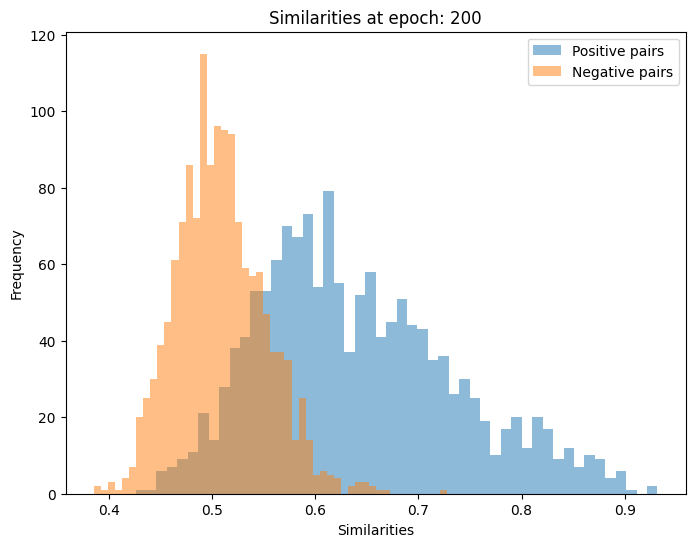

Accuracy=0.8372 at threshold=0.55
Training finished
History: {'loss': [0.5191329121589661, 0.5154998302459717, 0.5140570402145386, 0.5128670930862427, 0.5116243362426758, 0.5101863145828247, 0.5093832612037659, 0.5083345174789429, 0.5070071220397949, 0.5064111948013306], 'val_accuracy': [None, None, None, None, None, None, None, None, None, 0.8371527777777777], 'val_threshold': [None, None, None, None, None, None, None, None, None, 0.5527638190954774]}


In [70]:
@tf.function
def train_step(model, optimizer, images, labels,
               margin=0.15, gamma=16.0, negative_method='semi-hard'):
    with tf.GradientTape() as tape:
        embeddings = model(images, training=True)
        anchor_idx, pos_idx, neg_idx = get_triplets(
            embeddings, labels, margin=margin, negative_method=negative_method
        )
        anchor_emb = tf.gather(embeddings, anchor_idx)
        pos_emb    = tf.gather(embeddings, pos_idx)
        neg_emb    = tf.gather(embeddings, neg_idx)
        loss_value, sp, sn = circle_loss(
            anchor_emb, pos_emb, neg_emb,
            margin=margin, gamma=gamma
        )
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value, sp, sn, embeddings


def validation(
    model,
    label_to_filepaths,
    epoch,
    num_identities=32,
    images_per_identity=10,
): # not strictly a true validation as the dataset isn't split into train and test sets but since the dataset is so large and the relatively small batches are randomly selected, I'm not particularly worried about overfitting. 
    
    # I even actually tried to overfit the model for a while during experimentation to get a feel for the dataset and learning methods - I struggled to do this. 
    
    valid_labels = [
        lab for lab, paths in label_to_filepaths.items()
        if len(paths) >= images_per_identity
    ]
    chosen_labels = random.sample(valid_labels, k=num_identities)

    label_to_sampled_files = {}
    for lab in chosen_labels:
        paths_for_label = label_to_filepaths[lab]
        chosen_image_paths = random.sample(paths_for_label, k=images_per_identity)
        label_to_sampled_files[lab] = chosen_image_paths

    pairs = []
    all_chosen_labels = list(label_to_sampled_files.keys())

    for lab in all_chosen_labels:
        chosen_img_paths = label_to_sampled_files[lab]
        for i in range(len(chosen_img_paths)):
            for j in range(i + 1, len(chosen_img_paths)):
                pairs.append((chosen_img_paths[i], chosen_img_paths[j], 1))

    num_positive_pairs = len(pairs)
    negative_pairs_needed = num_positive_pairs
    negative_pairs = []

    while len(negative_pairs) < negative_pairs_needed:
        labA, labB = random.sample(all_chosen_labels, 2)
        pathA = random.choice(label_to_sampled_files[labA])
        pathB = random.choice(label_to_sampled_files[labB])
        negative_pairs.append((pathA, pathB, 0))

    pairs.extend(negative_pairs)

    similarities = []
    y_true = []

    for i, (pathA, pathB, label) in enumerate(pairs):
        try:

            tf_pathA = tf.convert_to_tensor(pathA, dtype=tf.string)
            tf_pathB = tf.convert_to_tensor(pathB, dtype=tf.string)

            imgA = decode_and_resize(tf_pathA)
            imgB = decode_and_resize(tf_pathB)

            imgA = tf.expand_dims(imgA, axis=0)
            imgB = tf.expand_dims(imgB, axis=0)

        except Exception as e:
            print(f"Skipping validation pair {i+1}, loading error: {e}")
            continue

        embA = model(imgA, training=False)
        embB = model(imgB, training=False)

        dot_product = tf.reduce_sum(embA * embB, axis=-1)
        similarity = (dot_product + 1.0) / 2.0

        similarities.append(similarity.numpy()[0])
        y_true.append(label)

    y_true = np.array(y_true)
    similarities = np.array(similarities)

    roc_auc = roc_auc_score(y_true, similarities)
    avg_precision = average_precision_score(y_true, similarities)

    pos_sims = similarities[y_true == 1]
    neg_sims = similarities[y_true == 0]

    thresholds = np.linspace(0.0, 1.0, 200)
    best_acc = 0.0
    best_thr = 0.5
    for thr in thresholds:
        y_pred = (similarities >= thr).astype(int)
        acc = np.mean(y_true == y_pred)
        if acc > best_acc:
            best_acc = acc
            best_thr = thr

    print(f"Validation set size: {len(y_true)} pairs")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Best Accuracy: {best_acc:.4f} at threshold={best_thr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.hist(pos_sims, bins=50, alpha=0.5, label="Positive pairs")
    plt.hist(neg_sims, bins=50, alpha=0.5, label="Negative pairs")
    plt.title(f"Similarities at epoch: {epoch}")
    plt.xlabel("Similarities")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    return {
        "best_accuracy": best_acc,
        "best_threshold": best_thr,
        "roc_auc": roc_auc,
        "average_precision": avg_precision
    }


def train_embedding_model(label_to_filepaths, model,
                          num_identities_per_batch,
                          images_per_identity,
                          epochs,
                          learning_rate,
                          margin,
                          gamma,
                          negative_method,
                          max_batches,
                          model_save_dir,
                          val_frequency,
                          ):

    dataset = build_triplet_compatible_dataset(
        label_to_filepaths=label_to_filepaths,
        num_identities_per_batch=num_identities_per_batch,
        images_per_identity=images_per_identity,
        max_batches=max_batches,
        shuffle=True
    )

    optimizer = optimizers.Adam(learning_rate)
    os.makedirs(model_save_dir, exist_ok=True)

    latest_epoch = 0
    latest_checkpoint = None

    with os.scandir(model_save_dir) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.startswith("model_epoch_") and entry.name.endswith(".weights.h5"):
                try:
                    epoch_num = int(entry.name.split('_')[-1].split('.')[0])
                    if epoch_num > latest_epoch:
                        latest_epoch = epoch_num
                        latest_checkpoint = entry.path
                except ValueError:
                    continue

    if latest_checkpoint:
        print(f"Warm start: loading checkpoint {latest_checkpoint} (epoch {latest_epoch})")
        model.load_weights(latest_checkpoint)

    start_epoch = latest_epoch + 1

    total_step = 0
    history = {
        "loss": [],
        "val_accuracy": [],
        "val_threshold": []
    }

    for epoch in range(start_epoch, epochs + 1):
        # Manual hacky learning rate schedule 
        if epoch> 15:
            learning_rate = learning_rate/10
        if epoch> 30:
            learning_rate = learning_rate/10
        if epoch> 45:
            learning_rate = learning_rate/10   
        if epoch> 60:
            learning_rate = learning_rate/2
        if epoch> 75:
            learning_rate = learning_rate/2
        if epoch> 90:
            learning_rate = learning_rate/2

        if epoch> 50: 
            negative_method="hard" # change to hard triplet mining after the first 50 epochs 


        print(f"Epoch {epoch}/{epochs}")
        start_time = time.time()
        epoch_loss_cumulative = 0.0
        batch_count = 0

        for batch_idx, (images, labels) in enumerate(dataset):
            step_start_time = time.time()
            batch_count += 1
            total_step += 1

            (loss_value, sp, sn, all_emb) = train_step(
                model, optimizer, images, labels,
                margin=margin, gamma=gamma,
                negative_method=negative_method,
            )

            epoch_loss_cumulative += loss_value

            if batch_idx % 50 == 0:
                loss_val_np = loss_value.numpy()
                sp_mean=  float(tf.reduce_mean(sp))
                sn_mean=  float(tf.reduce_mean(sn))
                step_time = time.time() - step_start_time

                print(
                    f"[Epoch {epoch}, batch {total_step}] "
                    f"Batch loss={loss_val_np:.6f}, "
                    f"sp mean={sp_mean:.4f} "
                    f"sn {negative_method} mean={sn_mean:.4f} "
                    f"Batch processing time={step_time:.4f}s"
                )


        ave_epoch_loss = epoch_loss_cumulative / batch_count
        history["loss"].append(float(ave_epoch_loss.numpy()))
        duration = time.time() - start_time
        print(f"Epoch {epoch} finished in {duration:.1f}s. Mean loss={ave_epoch_loss.numpy():.6f}")

        val_acc, val_thr = None, None
        if (epoch % val_frequency == 0):
            val_metrics = validation(model, label_to_filepaths,epoch)
            if val_metrics is not None:
                val_acc = val_metrics["best_accuracy"]
                val_thr = val_metrics["best_threshold"]
                print(f"Accuracy={val_acc:.4f} at threshold={val_thr:.2f}")
        history["val_accuracy"].append(val_acc)
        history["val_threshold"].append(val_thr)


        save_path = os.path.join(model_save_dir, f"model_epoch_{epoch}.weights.h5")
        model.save_weights(save_path)

    print("Training finished")
    return model, history

def main():
    label_to_filepaths = build_label_to_filepaths("./data/casia-webface")
    MODEL = build_shallow_inception_resnet_v2(
        input_shape=(112, 112, 3),
        embedding_dim=256)
    NUM_IDENTITIES_PER_BATCH = 50
    IMAGES_PER_IDENTITY = 5
    EPOCHS = 200
    LEARNING_RATE = 1e-4 # See learning rate schedule
    MARGIN = 0.15 # Tuned initally via gridsearch and then validated through trial and error experimentation
    GAMMA = 16 # Tuned initally via gridsearch and then validated through trial and error experimentation
    NEG_METHOD = 'semi-hard' # Updates to hard after epoch 50 
    MAX_BATCHES = 200
    VAL_FREQUENCY = 20

    model, history = train_embedding_model(
        label_to_filepaths=label_to_filepaths,
        model=MODEL,
        num_identities_per_batch=NUM_IDENTITIES_PER_BATCH,
        images_per_identity=IMAGES_PER_IDENTITY,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        margin=MARGIN,
        gamma=GAMMA,
        negative_method=NEG_METHOD,
        max_batches=MAX_BATCHES,
        model_save_dir="./ShallowInceptionV2",
        val_frequency=VAL_FREQUENCY, 
    )
    print("History:", history)

    return model 

# Warm starting at saved checkpoint (training done in stints to periodically observe convergence and to give my poor laptop fans a break)

trained_model = main()

#### Question 3 (Total 7 marks)

In this question you will view your trained model as a binary classifier that predicts whether two images are the same person or not. You will test your trained model on a subset of the Labeled Faces in the Wild (LFW) dataset. This dataset also consists of a number of identities, and a number of images per identity. It was introduced in the following paper:

* Huang, G.B., Ramesh, M., Berg, T., and Learned-Miller, E. (2007), "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments", University of Massachusetts, Amherst, Technical Report 07-49.

The subset is available for you in the folder `./data/labeled-faces-in-the-wild`.  There is also the file `lfw_test_pairs.txt` in the `./data` folder that you will use for testing. This file lists a number of pairs of images in the LFW dataset that either belong to the same identity or different identities.

_NB: if you have not been able to successfully train a model in question 2, you can still complete all of question 3 using any Keras model that takes images as input and returns embeddings. The results may not be good, but you can still demonstrate the methodology and implementation for testing the model._

a) You will now use your best model from question 2 to compute predictions on the LFW subset to say whether or not two images are the same person. 

Apply any appropriate data preprocessing to the images, and compute model embeddings and similarity scores for all images in the test data.

Display a histogram with the distribution of positive and negative similarity scores from your model.

**(4 marks)**

In [76]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def decode_and_resize_validation(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 175, 175) # zooming in slightly onto the face to better match training data
    img = tf.image.resize(img, [112, 112])
    return img

def validate_lfw(model, lfw_pairs_file="./data/lfw_test_pairs.txt", lfw_dir="./data/labeled-faces-in-the-wild"):
    with open(lfw_pairs_file, "r") as f:
        lines = f.readlines()
    
    pairs = []
    for line_num, line in enumerate(lines[1:], start=2):
        line = line.strip()
        if not line:
            continue
        
        parts = line.split()
        if len(parts) == 3:
            person_name = parts[0]
            img_id1 = int(parts[1])
            img_id2 = int(parts[2])
            pathA = os.path.join(lfw_dir, person_name, f"{person_name}_{img_id1:04d}.jpg")
            pathB = os.path.join(lfw_dir, person_name, f"{person_name}_{img_id2:04d}.jpg")
            label = 1  
        elif len(parts) == 4:
            person1 = parts[0]
            person2 = parts[2]
            img_id1 = int(parts[1])
            img_id2 = int(parts[3])
            pathA = os.path.join(lfw_dir, person1, f"{person1}_{img_id1:04d}.jpg")
            pathB = os.path.join(lfw_dir, person2, f"{person2}_{img_id2:04d}.jpg")
            label = 0 
        else:
            print(f"Skipping bad line {line_num}: {line}")
            continue
        
        pairs.append((pathA, pathB, label))

    similarities = []
    y_true = []
    
    for i, (pathA, pathB, label) in enumerate(pairs):

        imgA = decode_and_resize_validation(pathA)
        imgB = decode_and_resize_validation(pathB)
        imgA = ops.expand_dims(imgA, axis=0)
        imgB = ops.expand_dims(imgB, axis=0)

        embA = model(imgA, training=False)
        embB = model(imgB, training=False)

        dot_product = ops.sum(embA * embB, axis=-1)
        similarity = (dot_product + 1.0) / 2.0

        similarities.append(similarity.numpy()[0])
        y_true.append(label)

    y_true = np.array(y_true)
    similarities = np.array(similarities)

    auc_metric = keras.metrics.AUC(curve='ROC')
    auc_metric.update_state(y_true, similarities)
    roc_auc = auc_metric.result().numpy()
    
    pr_auc_metric = keras.metrics.AUC(curve='PR')
    pr_auc_metric.update_state(y_true, similarities)
    avg_precision = pr_auc_metric.result().numpy()

    thresholds = np.linspace(0.0, 1.0, 200)
    best_acc = 0.0
    best_thr = 0.5
    accs = []
    for thr in thresholds:
        y_pred = (similarities >= thr).astype(int)
        acc = np.mean(y_true == y_pred)
        accs.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_thr = thr

    print(f"Validation set size: {len(y_true)} pairs")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision (PR AUC): {avg_precision:.4f}")
    print(f"Best Accuracy: {best_acc:.4f} at threshold={best_thr:.2f}")


    plt.figure(figsize=(8, 6))
    plt.hist(similarities[y_true == 1], bins=50, alpha=0.5, label="Positive pairs")
    plt.hist(similarities[y_true == 0], bins=50, alpha=0.5, label="Negative pairs")
    plt.axvline(x=best_thr, color='r', linestyle='dashed', linewidth=2)
    plt.title("Similarities Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(thresholds,accs)
    plt.xlabel("Similarity Thresholds")
    plt.ylabel("Accuracy")
    plt.show()
    
    return {
        "best_accuracy": best_acc,
        "best_threshold": best_thr,
        "roc_auc": roc_auc,
        "average_precision": avg_precision
    }


Validation set size: 6000 pairs
ROC AUC: 0.8542
Average Precision (PR AUC): 0.8652
Best Accuracy: 0.7728 at threshold=0.74


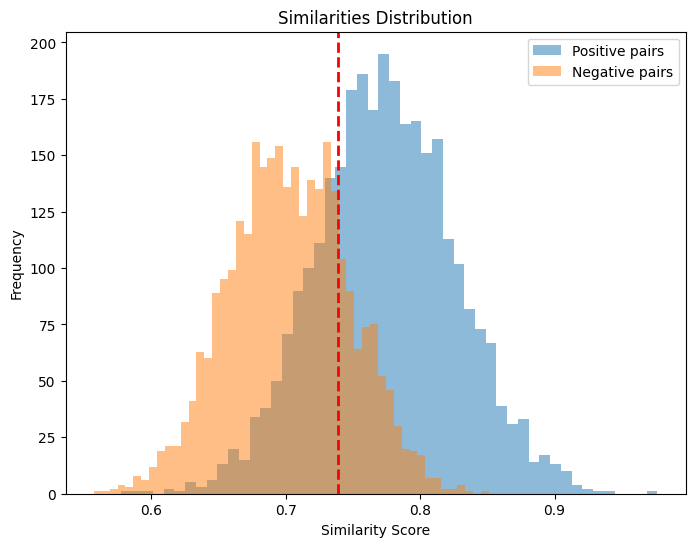

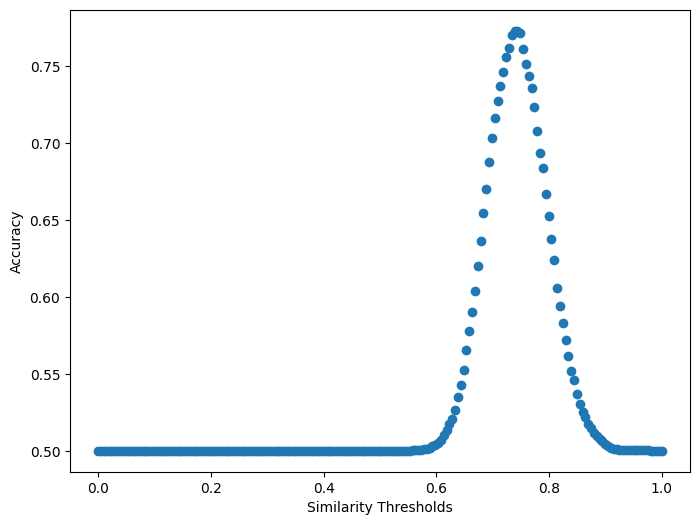

In [77]:
output = validate_lfw(trained_model)

b) Use the computed similarity scores from part a) to calculate the area under the ROC curve and the area under the precision-recall (PR) curve for your classifier model. Use the Keras `AUC` metric (see [the docs](https://keras.io/api/metrics/classification_metrics/#auc-class)) to do this.

Compute the threshold that maximises the accuracy of your classifier on the LFW test data. Plot the accuracy as a function of the threshold, and report the optimal threshold and resulting accuracy.

**(3 marks)**

**See above plots, functions and prints for the answer to this question. I put all of this testing stuff in one function to make it easier to call during experimentation**

#### Question 4 (Total 10 marks)

Provide a separate PDF report with an account of the experiments you have run in question 2. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time? What do you think are the most promising directions for performance gains?

Marks will be awarded for presentation and clarity. Your report should be no more than 3 pages, excluding references.

**(10 marks)**